In [5]:
!pip install pyvirtualdisplay Pillow


# SUMO Setups

In [6]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from tqdm import tqdm
from dotenv import load_dotenv
from gymnasium import spaces
import matplotlib.patches as patches
import shutil

SUMO_HOME = 'C:\\Program Files (x86)\\Eclipse\\Sumo'

os.environ['SUMO_HOME'] = SUMO_HOME

# Print the SUMO_HOME environment variable to verify
print("SUMO_HOME is set to:", os.environ.get('SUMO_HOME'))

# Check if the SUMO_HOME path exists
print("Does SUMO_HOME exist?", os.path.exists(os.environ.get('SUMO_HOME')))


# Define file paths
net_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.net.xml/osm.net.xml'
route_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.rou.xml'
out_csv_name = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.csv'
config_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.sumocfg'


SUMO_HOME is set to: C:\Program Files (x86)\Eclipse\Sumo
Does SUMO_HOME exist? True


## Importing Required libraries

In [7]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from tqdm import tqdm
import os
from dotenv import load_dotenv
import sumo_rl
import traci

# Environment Setup

In [8]:
class Environment:
    def __init__(self, env_name, route_file, net_file, out_csv_name, render_mode='human', num_seconds=100000):
        self.env_name = env_name
        self.use_gui = True if render_mode == 'human' else False
        self.route_file = route_file
        self.net_file = net_file
        self.out_csv_name = out_csv_name
        self.env = gym.make(
                        env_name,
                        net_file=net_file,
                        route_file=route_file,
                        out_csv_name=out_csv_name,
                        use_gui=self.use_gui,
                        num_seconds=num_seconds
                    )
     
        self.state, _ = self.env.reset()
        self.done = False
        self.observation_space = self.env.observation_space.shape[0]
        self.action_space = self.env.action_space
        self.traffic_signals = self.env.unwrapped.traffic_signals
    
    def reset(self):
        self.state, _ = self.env.reset()
        self.done = False
        return self.state
    
    def custom_reward(self, traffic_signal, reward_type='average_speed', reward_method='simple'):
        # print("Inside custom reward method")
        if reward_method == 'simple':
            match reward_type:
                case 'average_speed':
                    return traffic_signal.get_avgerage_speed()
                case 'congesion':
                    return -1 * traffic_signal.get_pressure()
                case 'emissions':
                    return -1* traffic_signal.get_emission_co2()
                case 'throughput':
                    return traffic_signal.get_throughput()

        else:
            # Weighted sum of the metrics
            reward = 0
            if weights is None:
                weights = {
                    'average_speed': 0.4,
                    'waiting_time': 0.3,
                    'emissions': 0.2,
                    'throughput': 0.1
                }

            # Calculate individual rewards
            average_speed = traffic_signal.get_average_speed()
            waiting_time = -1* traffic_signal._diff_waiting_time_reward()
            total_queue = -1 * traffic_signal.get_total_queued()
            congesion = traffic_signal.get_pressure()

            print(average_speed, waiting_time, total_queue, congesion)
            weighted_reward = (
                weights['average_speed'] * average_speed +
                weights['waiting_time'] * waiting_time +
                weights['emissions'] * total_queue +
                weights['throughput'] * congesion
            )

            return weighted_reward
            
            
    def step(self, action):
        # print("Inside step method")
        next_state, reward, terminated, truncated, info = self.env.step(action)
        # print("Step taken", next_state, terminated, truncated, info)

        # print("Traffic signals:", list(self.traffic_signals.values())[0])
        # traffic_signal = list(self.traffic_signals.values())[0]
        # print("Pressure:", traffic_signal.get_pressure())
        # # print(traffic_signal.get_average_speed(), traffic_signal.get_total_queued(), traffic_signal._diff_waiting_time_reward(), traffic_signal.get_pressure())
        # reward = self.custom_reward(traffic_signal, reward_type='congesion', reward_method='simple')
        # print("Reward:", reward)

        self.state = next_state
        self.done = terminated
        return next_state, reward, self.done or truncated
    
    def render(self):
        self.env.render()
    
    def close(self):
        try:
            self.env.close()
            if traci.isLoaded():
                traci.close()
            print("Env and Traci closed successfully.")
        except Exception as e:
            print("Error while closing the environment:", e)
    
    def get_state(self):
        return self.state


## Random Agent Run Basic

## Running Environment (Simple Intersection)

In [90]:
# Define paths to the network and route files (Buffalo Road Intersection)

# net_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.net.xml/osm.net.xml'
# route_file = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.rou.xml'
# out_csv_name = 'C:/Users/ASUS/Sumo/2024-11-03-18-23-47/osm.passenger.csv'


# Using Custom simple Traffic Intersection
nets_dir = 'nets/two_way'

file_name = 'single-intersection'

nets_file = os.path.join(nets_dir, f'{file_name}.net.xml')
routes_file = os.path.join(nets_dir, f'{file_name}-gen.rou.xml')
out_csv_name = os.path.join(nets_dir+"/results_csv", f'{file_name}.passenger.csv')

file_exists = lambda file_path: os.path.exists(file_path)

results_dir = os.path.join(nets_dir, 'results_csv')
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)
os.makedirs(results_dir, exist_ok=True)

if not file_exists(nets_file):
    raise FileNotFoundError(f"Net file not found: {net_file}")
if not file_exists(routes_file):
    raise FileNotFoundError(f"Route file not found: {route_file}")

sumo_env = Environment('sumo-rl-v0', net_file=nets_file, route_file=routes_file, out_csv_name=out_csv_name, render_mode=None, num_seconds=500)



print("Observation Space:", sumo_env.observation_space)
print("Action Space:", sumo_env.action_space.n)
print("Initial State:", sumo_env.state)


n_episodes = 100
p_bar = tqdm(range(n_episodes), colour='blue', desc='Random Agent Progress 100 episodes', unit='Episode', leave=True)

rewards_per_episode_random = {}
try:
    for episode in p_bar:
        print("Episode:", episode)
        done = False
        sumo_env.reset()
        total_reward = 0
        while not done:
            action = sumo_env.action_space.sample()
            next_state, reward, done = sumo_env.step(action)
            total_reward += reward
            # print("Action:", action, "Reward:", reward, "Done:", done, "Observation:", next_state)
            if done:
                sumo_env.reset()
                break
        rewards_per_episode_random[episode] = total_reward

except KeyboardInterrupt:
    print("Keyboard interrupt detected. Closing the environment.")

except Exception as e:
    print("Error occurred:", e)

finally:
    sumo_env.close()

print("Rewards per episode:", rewards_per_episode_random)

Observation Space: 21
Action Space: 4
Initial State: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Random Agent Progress 100 episodes:   0%|          | 0/100 [00:00<?, ?Episode/s]

Episode: 0


Random Agent Progress 100 episodes:   1%|          | 1/100 [00:14<24:07, 14.62s/Episode]

Episode: 1


Random Agent Progress 100 episodes:   2%|▏         | 2/100 [00:28<23:27, 14.36s/Episode]

Episode: 2


Random Agent Progress 100 episodes:   3%|▎         | 3/100 [00:42<22:57, 14.20s/Episode]

Episode: 3


Random Agent Progress 100 episodes:   4%|▍         | 4/100 [00:56<22:28, 14.05s/Episode]

Episode: 4


Random Agent Progress 100 episodes:   5%|▌         | 5/100 [01:11<22:42, 14.34s/Episode]

Episode: 5


Random Agent Progress 100 episodes:   6%|▌         | 6/100 [01:26<22:33, 14.40s/Episode]

Episode: 6


Random Agent Progress 100 episodes:   7%|▋         | 7/100 [01:41<22:38, 14.61s/Episode]

Episode: 7


Random Agent Progress 100 episodes:   8%|▊         | 8/100 [01:55<22:32, 14.70s/Episode]

Episode: 8


Random Agent Progress 100 episodes:   9%|▉         | 9/100 [02:10<22:16, 14.69s/Episode]

Episode: 9


Random Agent Progress 100 episodes:  10%|█         | 10/100 [02:24<21:46, 14.52s/Episode]

Episode: 10


Random Agent Progress 100 episodes:  11%|█         | 11/100 [02:39<21:36, 14.57s/Episode]

Episode: 11


Random Agent Progress 100 episodes:  12%|█▏        | 12/100 [02:54<21:23, 14.58s/Episode]

Episode: 12


Random Agent Progress 100 episodes:  13%|█▎        | 13/100 [03:08<21:10, 14.60s/Episode]

Episode: 13


Random Agent Progress 100 episodes:  14%|█▍        | 14/100 [03:22<20:41, 14.43s/Episode]

Episode: 14


Random Agent Progress 100 episodes:  15%|█▌        | 15/100 [03:37<20:24, 14.41s/Episode]

Episode: 15


Random Agent Progress 100 episodes:  16%|█▌        | 16/100 [03:51<20:19, 14.52s/Episode]

Episode: 16


Random Agent Progress 100 episodes:  17%|█▋        | 17/100 [04:06<19:59, 14.45s/Episode]

Episode: 17


Random Agent Progress 100 episodes:  18%|█▊        | 18/100 [04:19<19:30, 14.27s/Episode]

Episode: 18


Random Agent Progress 100 episodes:  19%|█▉        | 19/100 [04:34<19:17, 14.29s/Episode]

Episode: 19


Random Agent Progress 100 episodes:  20%|██        | 20/100 [04:48<19:08, 14.36s/Episode]

Episode: 20


Random Agent Progress 100 episodes:  21%|██        | 21/100 [05:02<18:42, 14.21s/Episode]

Episode: 21


Random Agent Progress 100 episodes:  22%|██▏       | 22/100 [05:17<18:37, 14.33s/Episode]

Episode: 22


Random Agent Progress 100 episodes:  23%|██▎       | 23/100 [05:30<18:01, 14.05s/Episode]

Episode: 23


Random Agent Progress 100 episodes:  24%|██▍       | 24/100 [05:45<18:04, 14.27s/Episode]

Episode: 24


Random Agent Progress 100 episodes:  25%|██▌       | 25/100 [05:59<17:48, 14.25s/Episode]

Episode: 25


Random Agent Progress 100 episodes:  26%|██▌       | 26/100 [06:13<17:20, 14.07s/Episode]

Episode: 26


Random Agent Progress 100 episodes:  27%|██▋       | 27/100 [06:27<17:05, 14.05s/Episode]

Episode: 27


Random Agent Progress 100 episodes:  28%|██▊       | 28/100 [06:42<17:19, 14.44s/Episode]

Episode: 28


Random Agent Progress 100 episodes:  29%|██▉       | 29/100 [06:57<17:06, 14.46s/Episode]

Episode: 29


Random Agent Progress 100 episodes:  30%|███       | 30/100 [07:11<16:53, 14.49s/Episode]

Episode: 30


Random Agent Progress 100 episodes:  31%|███       | 31/100 [07:25<16:27, 14.32s/Episode]

Episode: 31


Random Agent Progress 100 episodes:  32%|███▏      | 32/100 [07:40<16:28, 14.53s/Episode]

Episode: 32


Random Agent Progress 100 episodes:  33%|███▎      | 33/100 [07:55<16:14, 14.55s/Episode]

Episode: 33


Random Agent Progress 100 episodes:  34%|███▍      | 34/100 [08:09<15:47, 14.36s/Episode]

Episode: 34


Random Agent Progress 100 episodes:  35%|███▌      | 35/100 [08:24<15:42, 14.50s/Episode]

Episode: 35


Random Agent Progress 100 episodes:  36%|███▌      | 36/100 [08:38<15:27, 14.50s/Episode]

Episode: 36


Random Agent Progress 100 episodes:  37%|███▋      | 37/100 [08:52<14:54, 14.20s/Episode]

Episode: 37


Random Agent Progress 100 episodes:  38%|███▊      | 38/100 [09:06<14:49, 14.35s/Episode]

Episode: 38


Random Agent Progress 100 episodes:  39%|███▉      | 39/100 [09:20<14:31, 14.29s/Episode]

Episode: 39


Random Agent Progress 100 episodes:  40%|████      | 40/100 [09:34<14:08, 14.14s/Episode]

Episode: 40


Random Agent Progress 100 episodes:  41%|████      | 41/100 [09:49<14:05, 14.33s/Episode]

Episode: 41


Random Agent Progress 100 episodes:  42%|████▏     | 42/100 [10:03<13:53, 14.37s/Episode]

Episode: 42


Random Agent Progress 100 episodes:  43%|████▎     | 43/100 [10:17<13:21, 14.06s/Episode]

Episode: 43


Random Agent Progress 100 episodes:  44%|████▍     | 44/100 [10:31<13:17, 14.24s/Episode]

Episode: 44


Random Agent Progress 100 episodes:  45%|████▌     | 45/100 [10:46<13:16, 14.49s/Episode]

Episode: 45


Random Agent Progress 100 episodes:  46%|████▌     | 46/100 [11:01<13:09, 14.61s/Episode]

Episode: 46


Random Agent Progress 100 episodes:  47%|████▋     | 47/100 [11:16<12:54, 14.61s/Episode]

Episode: 47


Random Agent Progress 100 episodes:  48%|████▊     | 48/100 [11:30<12:34, 14.50s/Episode]

Episode: 48


Random Agent Progress 100 episodes:  49%|████▉     | 49/100 [11:45<12:23, 14.58s/Episode]

Episode: 49


Random Agent Progress 100 episodes:  50%|█████     | 50/100 [11:59<11:56, 14.33s/Episode]

Episode: 50


Random Agent Progress 100 episodes:  51%|█████     | 51/100 [12:13<11:37, 14.24s/Episode]

Episode: 51


Random Agent Progress 100 episodes:  52%|█████▏    | 52/100 [12:28<11:30, 14.39s/Episode]

Episode: 52


Random Agent Progress 100 episodes:  53%|█████▎    | 53/100 [12:41<11:03, 14.12s/Episode]

Episode: 53


Random Agent Progress 100 episodes:  54%|█████▍    | 54/100 [12:56<10:55, 14.25s/Episode]

Episode: 54


Random Agent Progress 100 episodes:  55%|█████▌    | 55/100 [13:10<10:44, 14.33s/Episode]

Episode: 55


Random Agent Progress 100 episodes:  56%|█████▌    | 56/100 [13:25<10:40, 14.55s/Episode]

Episode: 56


Random Agent Progress 100 episodes:  57%|█████▋    | 57/100 [13:39<10:16, 14.33s/Episode]

Episode: 57


Random Agent Progress 100 episodes:  58%|█████▊    | 58/100 [13:53<10:00, 14.29s/Episode]

Episode: 58


Random Agent Progress 100 episodes:  59%|█████▉    | 59/100 [14:07<09:39, 14.14s/Episode]

Episode: 59


Random Agent Progress 100 episodes:  60%|██████    | 60/100 [14:20<09:13, 13.84s/Episode]

Episode: 60


Random Agent Progress 100 episodes:  61%|██████    | 61/100 [14:34<08:59, 13.84s/Episode]

Episode: 61


Random Agent Progress 100 episodes:  62%|██████▏   | 62/100 [14:48<08:52, 14.02s/Episode]

Episode: 62


Random Agent Progress 100 episodes:  63%|██████▎   | 63/100 [15:02<08:39, 14.05s/Episode]

Episode: 63


Random Agent Progress 100 episodes:  64%|██████▍   | 64/100 [15:17<08:26, 14.06s/Episode]

Episode: 64


Random Agent Progress 100 episodes:  65%|██████▌   | 65/100 [15:30<08:10, 14.01s/Episode]

Episode: 65


Random Agent Progress 100 episodes:  66%|██████▌   | 66/100 [15:45<08:01, 14.15s/Episode]

Episode: 66


Random Agent Progress 100 episodes:  67%|██████▋   | 67/100 [16:00<07:52, 14.31s/Episode]

Episode: 67


Random Agent Progress 100 episodes:  68%|██████▊   | 68/100 [16:15<07:46, 14.58s/Episode]

Episode: 68


Random Agent Progress 100 episodes:  69%|██████▉   | 69/100 [16:29<07:27, 14.45s/Episode]

Episode: 69


Random Agent Progress 100 episodes:  70%|███████   | 70/100 [16:44<07:17, 14.59s/Episode]

Episode: 70


Random Agent Progress 100 episodes:  71%|███████   | 71/100 [16:59<07:03, 14.61s/Episode]

Episode: 71


Random Agent Progress 100 episodes:  72%|███████▏  | 72/100 [17:13<06:50, 14.65s/Episode]

Episode: 72


Random Agent Progress 100 episodes:  73%|███████▎  | 73/100 [17:29<06:41, 14.88s/Episode]

Episode: 73


Random Agent Progress 100 episodes:  74%|███████▍  | 74/100 [17:43<06:24, 14.79s/Episode]

Episode: 74


Random Agent Progress 100 episodes:  75%|███████▌  | 75/100 [17:57<06:04, 14.59s/Episode]

Episode: 75


Random Agent Progress 100 episodes:  76%|███████▌  | 76/100 [18:12<05:49, 14.55s/Episode]

Episode: 76


Random Agent Progress 100 episodes:  77%|███████▋  | 77/100 [18:26<05:29, 14.33s/Episode]

Episode: 77


Random Agent Progress 100 episodes:  78%|███████▊  | 78/100 [18:40<05:14, 14.28s/Episode]

Episode: 78


Random Agent Progress 100 episodes:  79%|███████▉  | 79/100 [18:54<04:58, 14.21s/Episode]

Episode: 79


Random Agent Progress 100 episodes:  80%|████████  | 80/100 [19:09<04:48, 14.42s/Episode]

Episode: 80


Random Agent Progress 100 episodes:  81%|████████  | 81/100 [19:23<04:33, 14.39s/Episode]

Episode: 81


Random Agent Progress 100 episodes:  82%|████████▏ | 82/100 [19:38<04:23, 14.64s/Episode]

Episode: 82


Random Agent Progress 100 episodes:  83%|████████▎ | 83/100 [19:52<04:01, 14.21s/Episode]

Episode: 83


Random Agent Progress 100 episodes:  84%|████████▍ | 84/100 [20:05<03:44, 14.05s/Episode]

Episode: 84


Random Agent Progress 100 episodes:  85%|████████▌ | 85/100 [20:19<03:30, 14.00s/Episode]

Episode: 85


Random Agent Progress 100 episodes:  86%|████████▌ | 86/100 [20:34<03:21, 14.37s/Episode]

Episode: 86


Random Agent Progress 100 episodes:  87%|████████▋ | 87/100 [20:49<03:07, 14.41s/Episode]

Episode: 87


Random Agent Progress 100 episodes:  88%|████████▊ | 88/100 [21:03<02:51, 14.26s/Episode]

Episode: 88


Random Agent Progress 100 episodes:  89%|████████▉ | 89/100 [21:18<02:40, 14.58s/Episode]

Episode: 89


Random Agent Progress 100 episodes:  90%|█████████ | 90/100 [21:32<02:23, 14.39s/Episode]

Episode: 90


Random Agent Progress 100 episodes:  91%|█████████ | 91/100 [21:47<02:10, 14.51s/Episode]

Episode: 91


Random Agent Progress 100 episodes:  92%|█████████▏| 92/100 [22:01<01:54, 14.27s/Episode]

Episode: 92


Random Agent Progress 100 episodes:  93%|█████████▎| 93/100 [22:14<01:39, 14.15s/Episode]

Episode: 93


Random Agent Progress 100 episodes:  94%|█████████▍| 94/100 [22:30<01:26, 14.50s/Episode]

Episode: 94


Random Agent Progress 100 episodes:  95%|█████████▌| 95/100 [22:44<01:12, 14.47s/Episode]

Episode: 95


Random Agent Progress 100 episodes:  96%|█████████▌| 96/100 [22:59<00:58, 14.62s/Episode]

Episode: 96


Random Agent Progress 100 episodes:  97%|█████████▋| 97/100 [23:13<00:43, 14.41s/Episode]

Episode: 97


Random Agent Progress 100 episodes:  98%|█████████▊| 98/100 [23:27<00:28, 14.27s/Episode]

Episode: 98


Random Agent Progress 100 episodes:  99%|█████████▉| 99/100 [23:40<00:13, 13.99s/Episode]

Episode: 99


Random Agent Progress 100 episodes: 100%|██████████| 100/100 [23:55<00:00, 14.36s/Episode]

Env and Traci closed successfully.
Rewards per episode: {0: -25.33, 1: -31.22, 2: -56.2, 3: -59.39, 4: -54.74, 5: -33.81, 6: -70.46, 7: -34.22, 8: -50.68, 9: -55.91, 10: -71.45, 11: -50.32, 12: -31.03, 13: -51.47, 14: -32.45, 15: -71.64, 16: -44.29, 17: -63.38, 18: -44.73, 19: -41.09, 20: -67.63, 21: -43.27, 22: -44.65, 23: -25.53, 24: -26.19, 25: -45.76, 26: -50.95, 27: -37.51, 28: -64.0, 29: -36.22, 30: -40.74, 31: -41.46, 32: -90.25, 33: -50.33, 34: -99.24, 35: -82.26, 36: -48.82, 37: -48.17, 38: -43.07, 39: -35.8, 40: -99.18, 41: -48.8, 42: -43.18, 43: -29.57, 44: -45.3, 45: -41.61, 46: -56.88, 47: -40.26, 48: -44.07, 49: -30.08, 50: -45.79, 51: -38.57, 52: -51.44, 53: -40.2, 54: -19.61, 55: -35.23, 56: -55.76, 57: -40.55, 58: -42.07, 59: -60.4, 60: -57.55, 61: -56.41, 62: -78.31, 63: -51.29, 64: -63.61, 65: -30.21, 66: -43.92, 67: -24.09, 68: -42.73, 69: -37.77, 70: -41.61, 71: -36.98, 72: -66.64, 73: -54.92, 74: -46.63, 75: -69.98, 76: -46.58, 77: -50.2, 78: -39.42, 79: -41.9, 80

# Training DQN

## DQN Network

In [10]:
# Setting up basic Neural Network for DQN
from torch import nn

input_nodes = 128

class DQN(nn.Module):
    def __init__(self, observation_size, action_size, input_nodes=128):
        super(DQN, self).__init__()
        print("Observation size Network", observation_size)
        print("Action size Network", action_size)

        self.fc1 = nn.Linear(observation_size, input_nodes)
        self.fc2 = nn.Linear(input_nodes, input_nodes)
        self.fc3 = nn.Linear(input_nodes, action_size)
        
    
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Replay Memory

In [11]:
# Class for Replay Memory
from collections import namedtuple, deque
import random

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DQN Agent

In [12]:
# Setting up the Agent Class for doing the DQN 
class Agent:
    def __init__(self, env, epsilon, gamma, learning_rate, epsilon_decay, mem_size=5000):
        self.env = env
        self.state_size = env.observation_space
        self.action_size = env.action_space.n
        self.epsilon = epsilon
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.min_epsilon = 0.01
        self.max_epsilon = 1
        self.epsilon_decay = epsilon_decay
        self.use_double_dqn = False

        self.memory_size_max = mem_size
        self.memory_buffer = ReplayMemory(self.memory_size_max)
        self.q_network = DQN(self.state_size, self.action_size)
        self.q_target_network = DQN(self.state_size, self.action_size)
        self.q_target_network.load_state_dict(self.q_network.state_dict())
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
    
    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = torch.FloatTensor(state).unsqueeze(0)    
            with torch.no_grad():
                q_values = self.q_network(state)
                return torch.argmax(q_values).item()
    
    def update_experience(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).unsqueeze(0)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        action = torch.LongTensor([action]).view(-1, 1)
        reward = torch.FloatTensor([reward]).to(torch.float32)
        done = torch.FloatTensor([done]).to(torch.float32)
        self.memory_buffer.push(state, action, next_state, reward, done)

        if self.memory_buffer.__len__() > self.memory_size_max:
            self.memory_buffer.pop(0)

    def update_exploration_probability(self, episode):
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.epsilon_decay * episode)
    
    def optimize(self, batch_size, sample_threshold=0.1):
        if len(self.memory_buffer) < batch_size:
            return
        
        if len(self.memory_buffer) < sample_threshold * self.memory_size_max:
            return

        transitions = self.memory_buffer.sample(batch_size)
        batch = Transition(*zip(*transitions))
        
        # Convert the parameters to torch tensors
        # state_batch = torch.cat(batch.state)
        # action_batch = torch.tensor(batch.action).view(-1, 1)
        # reward_batch = torch.tensor(batch.reward).float()
        # next_state_batch = torch.cat(batch.next_state)

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        next_state_batch = torch.cat(batch.next_state)
        done_batch = torch.cat(batch.done)

        curr_q_vals = self.q_network(state_batch)
        curr_q_vals = curr_q_vals.gather(1, action_batch)

        # update target q value and current q values, backpropagate the loss
        with torch.no_grad():
            next_q_vals = self.q_target_network(next_state_batch)
            max_next_q_vals = torch.max(next_q_vals, 1)[0]
            target_q_vals = reward_batch + self.gamma * max_next_q_vals * (1 - done_batch)

        loss = self.loss_function(curr_q_vals.squeeze(), target_q_vals)
        self.optimizer.zero_grad()
        loss.backward()
        # Handling the exploding gradient problem
        nn.utils.clip_grad_norm_(self.q_network.parameters(), 1)
        self.optimizer.step()

        return loss.item()
    
    def update_target_network(self):
        self.q_target_network.load_state_dict(self.q_network.state_dict())
    

## Trainer DQN

In [13]:
%pip install wandb

In [14]:
import wandb


class WanDB():
    def _init_(self, config, project, env, use_wandb):
        if use_wandb:
            wandb.init(project=project, config=config, name=env)
            self.config = wandb.config
            self.use_wandb = True
        else:
            self.config = config
            self.use_wandb = False

    def wandb_log(self, args):
        if self.use_wandb:
            wandb.log(args)
        else:
            print(args)

    def wandb_finish(self):
        if self.use_wandb:
          wandb.finish()

Exception ignored in: <function SumoEnvironment.__del__ at 0x0000013BA9094820>
Traceback (most recent call last):
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sumo_rl\environment\env.py", line 460, in __del__
    self.close()
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sumo_rl\environment\env.py", line 450, in close
    traci.close()
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\traci\main.py", line 262, in close
    connection.check().close(wait)
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\traci\connection.py", line 397, in close
    self._sendCmd(tc.CMD_CLOSE, None, None)
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\traci\connection.py", line 232, in _sendCmd
    return self._sendExact()
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\traci\connection.py", line 137, in _sendExact

In [15]:
def trainer_dqn(env, agent, n_episodes, batch_size, epsilon, gamma, learning_rate, epsilon_decay, C, max_steps=100, tau=0.005):
    max_steps = 500
    use_wandb = os.environ.get('USE_WANDB', 'false').lower() == 'true'
    epsilon_start = 1
    epsilon_end = 0.01

    if use_wandb:
        wandb_config = {
            'env': env.env_name,
            'algorithm': 'DQN',
            'batch_size': batch_size,
            'gamma': gamma,
            'eps_start': epsilon_start,
            'eps_end': epsilon_end,
            'eps_decay': epsilon_decay,
            'target_update': C,
            'lr': learning_rate,
            'num_episodes': n_episodes,
            'max_timesteps': max_steps,
            'seed': 0
        }

        method = 'DQN' if not agent.use_double_dqn else 'DoubleDQN'
        
        cust_wandb = WanDB(wandb_config, f'assignment-2-{env.env_name}', env.env_name)
    
    loss_list = []
    reward_list = []
    rewards_per_episode = {}
    epsilon_values = []

    p_bar = tqdm(range(n_episodes), colour='green', desc='Training progress', unit='Episode')
    tot_steps = 0

    try:
        for episode in p_bar:
            state = env.reset()
            done = False
            total_reward = 0
            total_loss = 0            

            while not done:
                tot_steps += 1
                action = agent.choose_action(state)

                # Environment step
                next_state, reward, done = env.step(action)

                # Updated for bidirectional setup
                # Ensure reward calculation balances traffic in both directions
                # Example: reward -= abs(left_queue - right_queue) for balancing
                
                agent.update_experience(state, action, reward, next_state, done)

                # Optimize the model
                loss = agent.optimize(batch_size)
                if loss:
                    if use_wandb:
                        cust_wandb.wandb_log({
                                'loss': loss, 
                                'step_reward': reward, 
                                'step': tot_steps
                            })
                    total_loss += loss

                total_reward += reward
                state = next_state

            if episode % C == 0:
                if agent.use_double_dqn:
                    agent.update_target_network(tau)
                else:
                    agent.update_target_network()

            agent.update_exploration_probability(episode)
            epsilon_values.append(agent.epsilon)

            loss_list.append(total_loss)
            reward_list.append(total_reward)
            rewards_per_episode[episode] = total_reward

            if use_wandb:
                cust_wandb.wandb_log({
                    'epsilon': agent.epsilon,
                    'total_reward': total_reward,
                    'total_loss': total_loss,
                    'episode': episode
                })

    except traci.exceptions.FatalTraCIError as e:
        print("TraCI error:", e)
    except KeyboardInterrupt:
        print("Keyboard interrupt detected. Closing the environment.")
    except Exception as e:
        print(f"Error occurred in episode {episode}, step {tot_steps}: {e}")
        raise
    finally:
        if use_wandb:
            cust_wandb.wandb_finish()
        print(f'Episode: {episode}, Total Reward: {total_reward}, Loss: {total_loss}')
    env.close()        
    return reward_list, loss_list, rewards_per_episode, epsilon_values


## Training Agent

In [16]:
# Trainer method

n_episodes = 1000
batch_size = 64
epsilon = 1
gamma = 0.99
learning_rate = 1e-3
epsilon_decay = 0.995
C = 5
num_seconds = 500

nets_dir = 'nets/two_way'

file_name = 'single-intersection'

nets_file = os.path.join(nets_dir, f'{file_name}.net.xml')
routes_file = os.path.join(nets_dir, f'{file_name}-gen.rou.xml')
out_csv_name = os.path.join(nets_dir+"/results_csv", f'{file_name}.passenger.csv')

file_exists = lambda file_path: os.path.exists(file_path)

results_dir = os.path.join(nets_dir, 'results_csv')
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)
os.makedirs(results_dir, exist_ok=True)

if not file_exists(nets_file):
    raise FileNotFoundError(f"Net file not found: {net_file}")
if not file_exists(routes_file):
    raise FileNotFoundError(f"Route file not found: {route_file}")

sumo_env = Environment('sumo-rl-v0', net_file=nets_file, route_file=routes_file, out_csv_name=out_csv_name, render_mode=None, num_seconds=num_seconds)


print("Observation Space:", sumo_env.observation_space)
print("Action Space:", sumo_env.action_space)
# print("Initial State:", sumo_env.state)

agent = Agent(sumo_env, epsilon, gamma, learning_rate, epsilon_decay)

rewards, losses, rewards_per_episode, epsilon_values = trainer_dqn(sumo_env, agent, n_episodes, batch_size, epsilon, gamma, learning_rate, epsilon_decay, C)

Observation Space: 21
Action Space: Discrete(4)
Observation size Network 21
Action size Network 4
Observation size Network 21
Action size Network 4


Training progress: 100%|██████████| 1000/1000 [3:10:32<00:00, 11.43s/Episode] 

Episode: 999, Total Reward: -21.76, Loss: 73.11001420021057
Env and Traci closed successfully.


In [42]:
torch.save(rewards, "dqn2way_rewards.pkl")
torch.save(losses, "dqn2way_losses.pkl")
torch.save(rewards_per_episode, "dqn2way_rewards_per_episode.pkl")
torch.save(epsilon_values, "dqn2way_epsilon_values.pkl")

## Evaluation

In [18]:
import pandas as pd

# Graph plotting methods
def epsilon_decay_plot(epsilon_values, environment_type):
  # plt.figure(figsize=(6, 4))
  plt.title(f'Epsilon Decay {environment_type}')
  plt.plot(epsilon_values)
  plt.xlabel('Episode', fontsize=18)
  plt.ylabel('Epsilon Values', fontsize=18)
  plt.title('Epsilon Decay', fontsize=26)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  # plt.ylim(ymin=0, ymax=1)
  # plt.xlim(xmin=0, xmax=500)
  plt.grid()
  plt.show()

def rewards_per_episode_plot(rewards_per_ep, environment_type, epsilons=[]):
  episodes = np.array(list(rewards_per_ep.keys())).flatten()
  rewards = np.array(list(rewards_per_ep.values())).flatten()

  plt.figure(figsize=(10, 6))
  plt.plot(episodes, rewards, marker='o', linestyle='-', markersize=4)
  plt.title(f'Rewards per Episode {environment_type}')
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.grid(True)
  plt.xticks(range(0, max(episodes)+1, max(1, len(episodes)//10)))

  plt.tight_layout()
  plt.show()

def rewards_per_episode_plot_2(rewards_per_ep, environment_type, epsilons=None, window_size=10):
    """
    Plots rewards per episode with optional smoothing.
    
    Args:
        rewards_per_ep (dict): A dictionary where keys are episodes and values are rewards.
        environment_type (str): The type of environment (for plot title).
        epsilons (list, optional): Epsilon values per episode, if you'd like to include them in the plot. Default is None.
        window_size (int, optional): The window size for moving average smoothing. Default is 10.
    """
    episodes = np.array(list(rewards_per_ep.keys())).flatten()
    rewards = np.array(list(rewards_per_ep.values())).flatten()

    plt.figure(figsize=(10, 6))
    plt.plot(episodes, rewards, marker='o', linestyle='-', markersize=4, label='Rewards per Episode')

    # Moving average for smoothing
    if window_size > 1:
        moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        plt.plot(episodes[:len(moving_avg)], moving_avg, color='r', label=f'Moving Avg (window={window_size})')

    plt.title(f'Rewards per Episode {environment_type}', fontsize=20)
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Reward', fontsize=14)
    plt.grid(True)
    
    # Include epsilon plot if provided
    if epsilons:
        ax2 = plt.gca().twinx()
        ax2.plot(episodes, epsilons, color='g', alpha=0.6, linestyle='--', label='Epsilon')
        ax2.set_ylabel('Epsilon', fontsize=14)
        ax2.tick_params(axis='y', labelsize=12)

    plt.legend()
    plt.tight_layout()
    plt.show()
    return plt


def combined_rewards_plot(rewards_list_1, rewards_list_2, labels, environment_type, window_size=10):
    """
    Plots rewards per episode for two separate reward lists with optional smoothing.

    Args:
        rewards_list_1 (dict): A dictionary where keys are episodes and values are rewards for the first set.
        rewards_list_2 (dict): A dictionary where keys are episodes and values are rewards for the second set.
        labels (tuple): A tuple containing the labels for the two reward lists (e.g., ('Model A', 'Model B')).
        environment_type (str): The type of environment (for plot title).
        window_size (int, optional): The window size for moving average smoothing. Default is 10.
    """
    # Extract episode and reward values for both reward lists
    episodes_1 = np.array(list(rewards_list_1.keys())).flatten()
    rewards_1 = np.array(list(rewards_list_1.values())).flatten()
    
    episodes_2 = np.array(list(rewards_list_2.keys())).flatten()
    rewards_2 = np.array(list(rewards_list_2.values())).flatten()
    
    plt.figure(figsize=(12, 7))

    # Plot first reward list
    plt.plot(episodes_1, rewards_1, marker='o', linestyle='-', markersize=4, label=f'{labels[0]} Rewards')

    # Plot moving average for the first reward list
    if window_size > 1:
        moving_avg_1 = np.convolve(rewards_1, np.ones(window_size) / window_size, mode='valid')
        plt.plot(episodes_1[:len(moving_avg_1)], moving_avg_1, linestyle='--', color='r', alpha=0.8, label=f'{labels[0]} Moving Avg')

    # Plot second reward list
    plt.plot(episodes_2, rewards_2, marker='s', linestyle='-', markersize=4, label=f'{labels[1]} Rewards')

    # Plot moving average for the second reward list
    if window_size > 1:
        moving_avg_2 = np.convolve(rewards_2, np.ones(window_size) / window_size, mode='valid')
        plt.plot(episodes_2[:len(moving_avg_2)], moving_avg_2, linestyle='--', color='b', alpha=0.8, label=f'{labels[1]} Moving Avg')

    plt.title(f'Comparison of Rewards per Episode: {environment_type}', fontsize=20)
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Reward', fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    return plt


def plot_results_csv_per_step(folder_path="nets/results_csv", plot_steps=False, plot_episodes=True):
  # folder_path = "nets/results_csv"

  global_steps = []
  global_cumulative_waiting_times = []

  current_step = 0

  global_episodes = []
  episode_numbers = []
  cumulative_waiting_times = []

  for episode_idx, file_name in enumerate(sorted(os.listdir(folder_path)), start=1):
      if file_name.endswith(".csv"):
          file_path = os.path.join(folder_path, file_name)
          data = pd.read_csv(file_path)

          if plot_steps:
            steps = data['step'] + current_step
            cumulative_waiting_time = data['system_total_waiting_time'].cumsum()
            
            global_steps.extend(steps)
            global_cumulative_waiting_times.extend(cumulative_waiting_time)

            current_step += data['step'].iloc[-1] + 1

          else:        
            # Compute the total cumulative waiting time for the episode
            total_waiting_time = data['system_total_waiting_time'].sum()
            
            # Append episode number and total waiting time
            episode_numbers.append(episode_idx)
            cumulative_waiting_times.append(total_waiting_time)

  # Plot the data
  plt.figure(figsize=(12, 6))
  if plot_episodes:
    plt.plot(episode_numbers, cumulative_waiting_times, label="Cumulative Waiting Time", color='red')
  if plot_steps:
    plt.plot(global_steps, global_cumulative_waiting_times, label="Cumulative Waiting Time", color='blue')

  # Add title, labels, grid, and legend
  title_text = "Cumulative Waiting Time vs Total Steps Across Episodes" if plot_steps else "Cumulative Waiting Time vs Total Episodes"
  plt.title(title_text)
  plt.xlabel(f"Total {'Steps' if plot_steps else 'Episodes'}")
  plt.ylabel("Cumulative Waiting Time")
  plt.grid(True)
  plt.legend()
  plt.show()

def plot_results_csv_per_episode(folder_path="nets/results_csv"):
  episode_numbers = []
  cumulative_waiting_times = []

  # Iterate over all files in the folder, sorted by filename for consistency
  for episode_idx, file_name in enumerate(sorted(os.listdir(folder_path)), start=1):
      if file_name.endswith(".csv"):
          # Load the CSV file
          file_path = os.path.join(folder_path, file_name)
          data = pd.read_csv(file_path)
          
          # Compute the total cumulative waiting time for the episode
          total_waiting_time = data['system_total_waiting_time'].sum()
          
          # Append episode number and total waiting time
          episode_numbers.append(episode_idx)
          cumulative_waiting_times.append(total_waiting_time)

  # Plot the data
  plt.figure(figsize=(12, 6))
  plt.plot(episode_numbers, cumulative_waiting_times, marker='o', linestyle='-', color='b', alpha=0.8)

  # Add title, labels, grid, and legend
  plt.title("Total Waiting Time vs Episodes")
  plt.xlabel("Episode")
  plt.ylabel("Total Waiting Time (Cumulative Sum)")
  plt.grid(True)
  plt.show()



### Random Agent rewards per episode plot

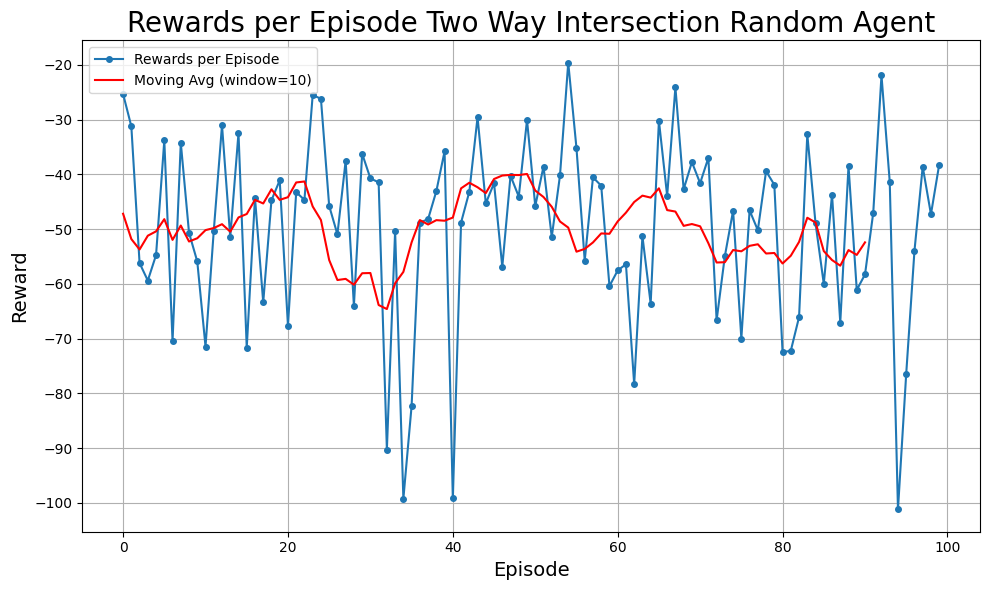

<module 'matplotlib.pyplot' from 'c:\\Users\\ASUS\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [91]:
rewards_per_episode_plot_2(rewards_per_episode_random, 'Two Way Intersection Random Agent', epsilon_values, window_size=10)

## Rewards Per Epsiode plot of DQN

Average Rewards: -20.685869999999998


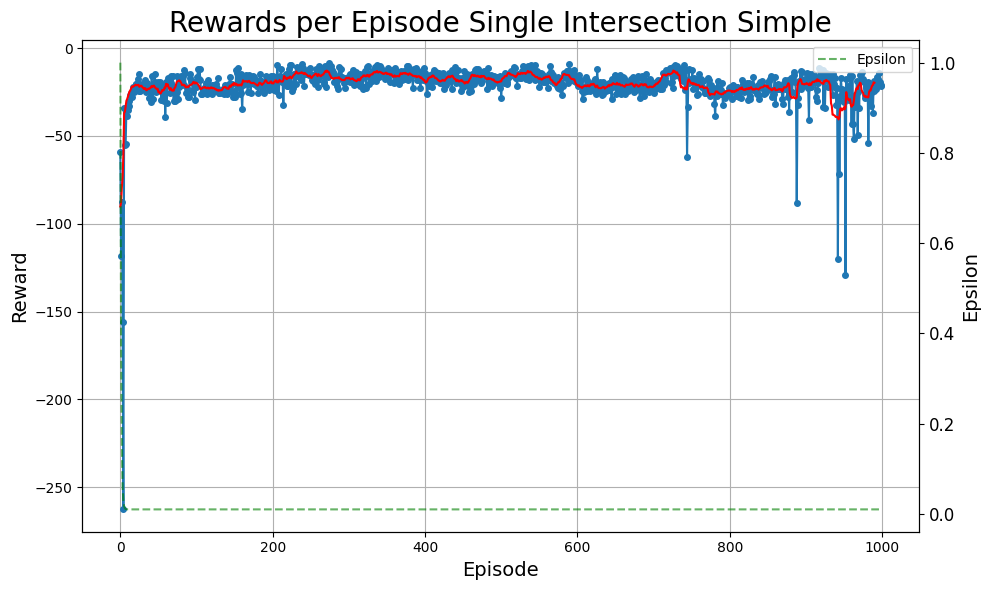

<module 'matplotlib.pyplot' from 'c:\\Users\\ASUS\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:
print("Average Rewards:", np.mean(rewards))
rewards_per_episode_plot_2(rewards_per_episode, 'Two Way Intersection Simple', epsilon_values, window_size=10)

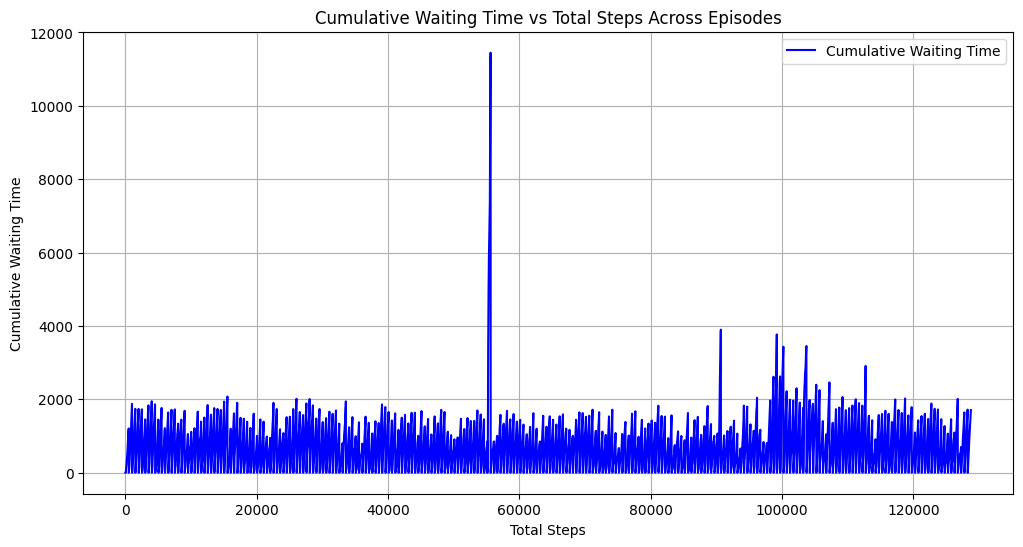

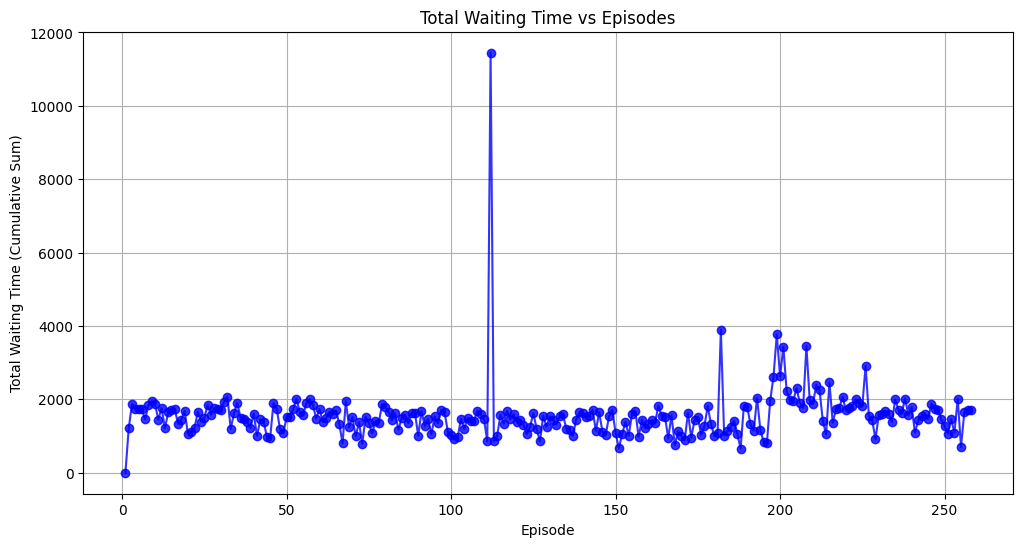

In [20]:
plot_results_csv_per_step(folder_path="nets/results_csv", plot_steps=True, plot_episodes=False)
plot_results_csv_per_episode(folder_path="nets/results_csv")

In [21]:
torch.save(agent.q_network.state_dict(), 'sumo_dqn2way.pth')

## Greedy Evaluation

In [22]:
def greedy_agent(agent, model, env, n_episodes=100):
    """
    Greedy agent for evaluating a trained model on a given environment.
    Args:
        agent: The agent interacting with the environment (not used here explicitly for greedy evaluation).
        model: The trained DQN model.
        env: The Gym-like environment.
        n_episodes: Number of episodes for evaluation.

    Returns:
        avg_rewards_over_eps: Average reward over all episodes.
        rewards_per_episode: Dictionary of rewards per episode.
        epsilon_values: Empty list since epsilon is always 0 for a greedy agent.
    """
    epsilon = 0  # For greedy, it chooses only exploitation
    reward_list = []
    rewards_per_episode = {}
    epsilon_values = []  # Empty, as epsilon is fixed at 0.

    p_bar = tqdm(range(n_episodes), colour='red', desc='Testing Progress', unit='Episode')

    model.eval()
    total_rewards = []

    for episode in p_bar:
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            # Ensure the state is correctly formatted for the model
            if isinstance(state, np.ndarray):
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
            else:
                raise ValueError(f"Unexpected state type: {type(state)}")

            # Predict Q-values and choose the best action
            with torch.no_grad():
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()

            # Take the action in the environment
            step_output = env.step(action)
            if len(step_output) == 4:
                next_state, reward, done, _ = step_output  # For environments returning additional info
            else:
                next_state, reward, done = step_output

            # Accumulate reward and update state
            episode_reward += reward
            state = next_state

        reward_list.append(episode_reward)
        rewards_per_episode[episode] = episode_reward

    # Compute the average reward over episodes
    rewards_per_ep_array = np.array(list(rewards_per_episode.values())).flatten()
    avg_rewards_over_eps = np.mean(rewards_per_ep_array)

    return avg_rewards_over_eps, rewards_per_episode, epsilon_values




In [23]:
# Instantiate the model and load the trained weights
model = DQN(sumo_env.observation_space, sumo_env.action_space.n)
model.load_state_dict(torch.load('sumo_dqn2way.pth'))

# Evaluate the model with the greedy agent
greedy_avg_rewards_over_eps, greedy_rewards_per_eps, epsilon_values = greedy_agent(
    agent, model, sumo_env, n_episodes=100
)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14292\2696929291.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('sumo_dqn2way.pth'))


Observation size Network 21
Action size Network 4


Testing Progress:   0%|          | 0/100 [00:00<?, ?Episode/s]

Testing Progress: 100%|██████████| 100/100 [17:55<00:00, 10.75s/Episode]


Avg Rewards per episode for Greedy Agent:  -17.4716


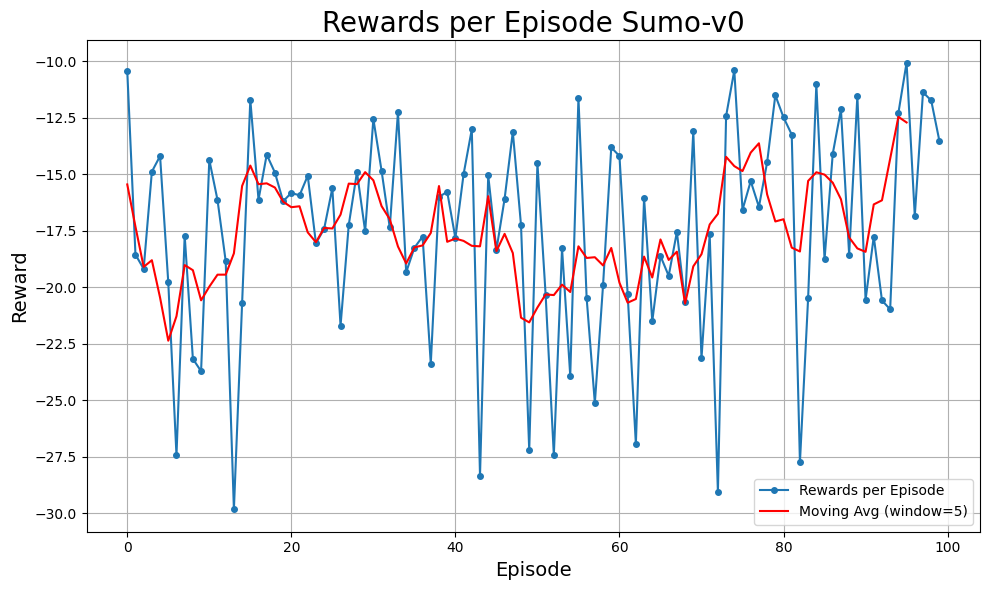

<module 'matplotlib.pyplot' from 'c:\\Users\\ASUS\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [24]:
print("Avg Rewards per episode for Greedy Agent: ", greedy_avg_rewards_over_eps)
rewards_per_episode_plot_2(greedy_rewards_per_eps, 'Sumo-v0', window_size=5)

## Saving the simulation with best episode for Random agent

In [94]:
# Saving simulation of random agent to gif
import imageio, time

def random_agent_with_recording(env, num_seconds=500, n_episodes=100, save_path="random_simulation_record"):
    """
    Random agent that records one episode of SUMO simulation.
    """
    # First find the best episode with render_mode=None
    best_reward = float('-inf')
    best_seed = None
    episode_seeds = {}
    
    original_env = env
    # Create environment without GUI for evaluation
    env = Environment('sumo-rl-v0', 
                     net_file=original_env.net_file,
                     route_file=original_env.route_file,
                     out_csv_name=original_env.out_csv_name,
                     render_mode=None,
                     num_seconds=num_seconds)
    
    p_bar = tqdm(range(n_episodes), colour='blue', desc='Finding Best Random Episode', unit='Episode')
    
    for episode in p_bar:
        seed = np.random.randint(0, 10000)
        np.random.seed(seed)
        
        state = env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            action = env.action_space.sample()
            next_state, reward, done = env.step(action)
            episode_reward += reward
            state = next_state
            
        episode_seeds[episode] = (seed, episode_reward)
        
        if episode_reward > best_reward:
            best_reward = episode_reward
            best_seed = seed
            
    print(f"Best random episode reward: {best_reward}")
    
    # Now record the best episode with GUI
    env.close()

    env = Environment('sumo-rl-v0', 
                     net_file=original_env.net_file,
                     route_file=original_env.route_file,
                     out_csv_name=original_env.out_csv_name,
                     render_mode="human",
                     num_seconds=num_seconds)
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    np.random.seed(best_seed)
    state = env.reset()
    done = False
    step = 0
    
    while not done:
        action = env.action_space.sample()
        next_state, reward, done = env.step(action)
        state = next_state
        
        screenshot_path = f'{save_path}/frame_{step:05d}.png'
        if hasattr(traci, 'gui'):
            traci.gui.screenshot('View #0', screenshot_path)
            time.sleep(0.1)
            
            if os.path.exists(screenshot_path):
                img = Image.open(screenshot_path)
                img = img.resize((800, 600))
                img.save(screenshot_path)
        
        step += 1
    
    env.close()
    # Create GIF
    images = []
    for filename in sorted(os.listdir(save_path)):
        if filename.endswith('.png'):
            images.append(imageio.imread(os.path.join(save_path, filename)))
    
    imageio.mimsave(f'{save_path}/random_best_episode.gif', images, fps=10)
    
    # Cleanup frame images
    for filename in os.listdir(save_path):
        if filename.endswith('.png'):
            os.remove(os.path.join(save_path, filename))
            
    print("Frame images cleaned up successfully")
    
    return best_reward, episode_seeds

# Usage
best_reward, episode_seeds = random_agent_with_recording(sumo_env, n_episodes=10)

Finding Best Random Episode: 100%|██████████| 10/10 [02:13<00:00, 13.40s/Episode]


Best random episode reward: -28.96
Env and Traci closed successfully.
Env and Traci closed successfully.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14292\3237515709.py:86: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(save_path, filename)))


Frame images cleaned up successfully


In [75]:
def greedy_agent_with_best_recording(agent, model, env, num_seconds, n_episodes=100, save_path="simulation_record"):
    """
    Finds the best episode and records its simulation
    """
    # First, run evaluation to find best episode
    original_env = env
    env.close()  # Close any existing environment
    
    # Create new environment instance with render_mode=None for evaluation
    env = Environment('sumo-rl-v0', 
                     net_file=original_env.net_file,
                     route_file=original_env.route_file,
                     out_csv_name=original_env.out_csv_name,
                     render_mode=None,
                     num_seconds=num_seconds)
    
    best_reward = float('-inf')
    best_seed = None
    
    p_bar = tqdm(range(n_episodes), colour='red', desc='Finding Best Episode', unit='Episode')
    
    # Store seeds and rewards
    episode_seeds = {}
    
    for episode in p_bar:
        # Store random seed before episode
        seed = np.random.randint(0, 10000)
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()
            next_state, reward, done = env.step(action)
            episode_reward += reward
            state = next_state

        episode_seeds[episode] = (seed, episode_reward)
        
        if episode_reward > best_reward:
            best_reward = episode_reward
            best_seed = seed

    print(f"Best episode reward: {best_reward}")
    env.close()
    
    # Now record the best episode
    np.random.seed(best_seed)
    torch.manual_seed(best_seed)
    
    env = Environment('sumo-rl-v0', 
                     net_file=original_env.net_file,
                     route_file=original_env.route_file,
                     out_csv_name=original_env.out_csv_name,
                     render_mode="human",
                     num_seconds=num_seconds)
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    state = env.reset()
    done = False
    step = 0
    
    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()

        next_state, reward, done = env.step(action)
        state = next_state
        
        screenshot_path = f'{save_path}/frame_{step:05d}.png'
        if hasattr(traci, 'gui'):
            traci.gui.screenshot('View #0', screenshot_path)
            time.sleep(0.1)
            
            if os.path.exists(screenshot_path):
                img = Image.open(screenshot_path)
                img = img.resize((800, 600))
                img.save(screenshot_path)
        
        step += 1

    print(f"Episode completed with reward: {episode_reward}")
    env.close()

    # Create GIF
    images = []
    for filename in sorted(os.listdir(save_path)):
        if filename.endswith('.png'):
            images.append(imageio.imread(os.path.join(save_path, filename)))
    
    imageio.mimsave(f'{save_path}/best_episode_simulation.gif', images, fps=10)

    # After creating the GIF
    imageio.mimsave(f'{save_path}/best_episode_simulation.gif', images, fps=10)

    # Cleanup: remove all frame images
    for filename in os.listdir(save_path):
        if filename.endswith('.png'):
            os.remove(os.path.join(save_path, filename))

    print("Frame images cleaned up successfully")
    
    return best_reward, episode_seeds

In [96]:
sumo_env = Environment('sumo-rl-v0', 
                 net_file=nets_file, 
                 route_file=routes_file, 
                 out_csv_name=out_csv_name, 
                 render_mode=None,  # Enable GUI
                 num_seconds=num_seconds)

save_path = "best_simulation_record/dqn2way"
model = DQN(sumo_env.observation_space, sumo_env.action_space.n)
model.load_state_dict(torch.load('sumo_dqn2way.pth'))

if os.path.exists(save_path):
    shutil.rmtree(save_path)
    os.makedirs(save_path, exist_ok=True)

greedy_agent_with_best_recording(agent, model, sumo_env, num_seconds=num_seconds ,n_episodes=10, save_path=save_path)

Observation size Network 21
Action size Network 4
Env and Traci closed successfully.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14292\2075415930.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('sumo_dqn2way.pth'))
Findin

Best episode reward: -12.6
Env and Traci closed successfully.
 Retrying in 1 seconds
Episode completed with reward: -22.47
Env and Traci closed successfully.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14292\1152363643.py:99: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(save_path, filename)))


Frame images cleaned up successfully


(-12.6,
 {0: (2899, -19.71),
  1: (6987, -18.53),
  2: (5890, -15.07),
  3: (9710, -12.6),
  4: (3179, -17.71),
  5: (6571, -14.97),
  6: (1445, -17.13),
  7: (2340, -19.49),
  8: (6435, -14.7),
  9: (7423, -22.47)})

# Training Double DQN

## Double DQN Agent

In [25]:
# Setting up the Agent Class for doing the DQN 
class DDQNAgent:
    def __init__(self, env, epsilon, gamma, learning_rate, epsilon_decay, mem_size=5000, use_double_dqn=False):
        self.env = env
        self.state_size = env.observation_space
        self.action_size = env.action_space.n
        self.epsilon = epsilon
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.min_epsilon = 0.01
        self.max_epsilon = 1
        self.epsilon_decay = epsilon_decay
        self.use_double_dqn = use_double_dqn

        print(self.state_size, self.action_size)

        self.memory_size_max = mem_size
        self.memory_buffer = ReplayMemory(self.memory_size_max)
        self.q_network = DQN(self.state_size, self.action_size)
        self.q_target_network = DQN(self.state_size, self.action_size)
        self.q_target_network.load_state_dict(self.q_network.state_dict())
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
    
    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = torch.FloatTensor(state).unsqueeze(0)    
            with torch.no_grad():
                q_values = self.q_network(state)
                return torch.argmax(q_values).item()
    
    def update_experience(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).unsqueeze(0)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        action = torch.LongTensor([action]).view(-1, 1)
        reward = torch.FloatTensor([reward]).to(torch.float32)
        done = torch.FloatTensor([done]).to(torch.float32)
        self.memory_buffer.push(state, action, next_state, reward, done)

        if self.memory_buffer.__len__() > self.memory_size_max:
            self.memory_buffer.pop(0)

    def update_exploration_probability(self, episode):
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.epsilon_decay * episode)
    
    def optimize(self, batch_size, sample_threshold=0.1):
        if len(self.memory_buffer) < batch_size:
            return
        
        if len(self.memory_buffer) < sample_threshold * self.memory_size_max:
            return

        transitions = self.memory_buffer.sample(batch_size)
        batch = Transition(*zip(*transitions))
        
        # Convert the parameters to torch tensors
        # state_batch = torch.cat(batch.state)
        # action_batch = torch.tensor(batch.action).view(-1, 1)
        # reward_batch = torch.tensor(batch.reward).float()
        # next_state_batch = torch.cat(batch.next_state)

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        next_state_batch = torch.cat(batch.next_state)
        done_batch = torch.cat(batch.done)

        curr_q_vals = self.q_network(state_batch)
        curr_q_vals = curr_q_vals.gather(1, action_batch)

        # update target q value and current q values, backpropagate the loss
        with torch.no_grad():
            if self.use_double_dqn:
                next_q_vals_online = self.q_network(next_state_batch)
                max_next_q_vals_online = torch.argmax(next_q_vals_online, dim=1, keepdim=True)
                next_q_vals_target = self.q_target_network(next_state_batch).gather(1, max_next_q_vals_online)
                target_q_vals = reward_batch + self.gamma * next_q_vals_target.squeeze() * (1 - done_batch)

            else:
                next_q_vals = self.q_target_network(next_state_batch)
                max_next_q_vals = torch.max(next_q_vals, 1)[0]
                target_q_vals = reward_batch + self.gamma * max_next_q_vals * (1 - done_batch)

        loss = self.loss_function(curr_q_vals.squeeze(), target_q_vals)
        self.optimizer.zero_grad()
        loss.backward()
        # Handling the exploding gradient problem
        nn.utils.clip_grad_norm_(self.q_network.parameters(), 10)
        self.optimizer.step()

        return loss.item()
    
    # def update_target_network(self):
    #     self.q_target_network.load_state_dict(self.q_network.state_dict())

    def update_target_network(self, tau=0.005):
        target_net_state_dict = self.q_target_network.state_dict()
        policy_net_state_dict = self.q_network.state_dict()
        counter = 0

        target_net_state_dict = self.q_target_network.state_dict()
        policy_net_state_dict = self.q_network.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * tau + target_net_state_dict[key] * (1 - tau)

        self.q_target_network.load_state_dict(target_net_state_dict)

        # for q_weight, target_weight in zip(policy_net_state_dict.values(), target_net_state_dict.values()):
        #     target_weight = target_weight * (1 - tau) + q_weight * tau
        #     target_net_state_dict[counter] = target_weight
        #     counter += 1

        # self.q_target_network.load_state_dict(target_net_state_dict)

        # for key in policy_net_state_dict:
        #     target_net_state_dict[key] = policy_net_state_dict[key] * tau + target_net_state_dict[key] * (1 - tau)
        # self.q_target_network.load_state_dict(target_net_state_dict)
    

In [26]:
class DDQNAgent:
    def __init__(self, env, epsilon, gamma, learning_rate, epsilon_decay, mem_size=5000, use_double_dqn=False):
        self.env = env
        
        # Handle different observation space types
        if hasattr(env.observation_space, 'shape'):
            self.state_size = env.observation_space.shape[0]  # For spaces like Box
        else:
            self.state_size = env.observation_space  # For scalar or integer spaces

        self.action_size = env.action_space.n  # Assuming Discrete(n) for action space
        self.epsilon = epsilon
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.min_epsilon = 0.01
        self.max_epsilon = 1
        self.epsilon_decay = epsilon_decay
        self.use_double_dqn = use_double_dqn

        print(f"Observation Space Size: {self.state_size}, Action Space Size: {self.action_size}")

        self.memory_size_max = mem_size
        self.memory_buffer = ReplayMemory(self.memory_size_max)
        self.q_network = DQN(self.state_size, self.action_size)
        self.q_target_network = DQN(self.state_size, self.action_size)
        self.q_target_network.load_state_dict(self.q_network.state_dict())
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
    
    def choose_action(self, state):
        """
        Choose an action based on epsilon-greedy policy.
        Adjust state processing if bidirectional environment uses a different representation.
        """
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = torch.FloatTensor(state).unsqueeze(0)  # Adjust state format if needed for bidirectional
            with torch.no_grad():
                q_values = self.q_network(state)
                return torch.argmax(q_values).item()
    
    def update_experience(self, state, action, reward, next_state, done):
        """
        Store the transition in memory. Ensure state formatting aligns with bidirectional dynamics.
        """
        state = torch.FloatTensor(state).unsqueeze(0)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        action = torch.LongTensor([action]).view(-1, 1)
        reward = torch.FloatTensor([reward]).to(torch.float32)
        done = torch.FloatTensor([done]).to(torch.float32)
        self.memory_buffer.push(state, action, next_state, reward, done)

        if self.memory_buffer.__len__() > self.memory_size_max:
            self.memory_buffer.pop(0)

    # Rest of the methods remain largely the same...

    def update_exploration_probability(self, episode):
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.epsilon_decay * episode)
    
    def optimize(self, batch_size, sample_threshold=0.1):
        if len(self.memory_buffer) < batch_size:
            return
        
        if len(self.memory_buffer) < sample_threshold * self.memory_size_max:
            return

        transitions = self.memory_buffer.sample(batch_size)
        batch = Transition(*zip(*transitions))
        
        # Convert the parameters to torch tensors
        # state_batch = torch.cat(batch.state)
        # action_batch = torch.tensor(batch.action).view(-1, 1)
        # reward_batch = torch.tensor(batch.reward).float()
        # next_state_batch = torch.cat(batch.next_state)

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        next_state_batch = torch.cat(batch.next_state)
        done_batch = torch.cat(batch.done)

        curr_q_vals = self.q_network(state_batch)
        curr_q_vals = curr_q_vals.gather(1, action_batch)

        # update target q value and current q values, backpropagate the loss
        with torch.no_grad():
            if self.use_double_dqn:
                next_q_vals_online = self.q_network(next_state_batch)
                max_next_q_vals_online = torch.argmax(next_q_vals_online, dim=1, keepdim=True)
                next_q_vals_target = self.q_target_network(next_state_batch).gather(1, max_next_q_vals_online)
                target_q_vals = reward_batch + self.gamma * next_q_vals_target.squeeze() * (1 - done_batch)

            else:
                next_q_vals = self.q_target_network(next_state_batch)
                max_next_q_vals = torch.max(next_q_vals, 1)[0]
                target_q_vals = reward_batch + self.gamma * max_next_q_vals * (1 - done_batch)

        loss = self.loss_function(curr_q_vals.squeeze(), target_q_vals)
        self.optimizer.zero_grad()
        loss.backward()
        # Handling the exploding gradient problem
        nn.utils.clip_grad_norm_(self.q_network.parameters(), 10)
        self.optimizer.step()

        return loss.item()
    
    # def update_target_network(self):
    #     self.q_target_network.load_state_dict(self.q_network.state_dict())

    def update_target_network(self, tau=0.005):
        target_net_state_dict = self.q_target_network.state_dict()
        policy_net_state_dict = self.q_network.state_dict()
        counter = 0

        target_net_state_dict = self.q_target_network.state_dict()
        policy_net_state_dict = self.q_network.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * tau + target_net_state_dict[key] * (1 - tau)

        self.q_target_network.load_state_dict(target_net_state_dict)

        # for q_weight, target_weight in zip(policy_net_state_dict.values(), target_net_state_dict.values()):
        #     target_weight = target_weight * (1 - tau) + q_weight * tau
        #     target_net_state_dict[counter] = target_weight
        #     counter += 1

        # self.q_target_network.load_state_dict(target_net_state_dict)

        # for key in policy_net_state_dict:
        #     target_net_state_dict[key] = policy_net_state_dict[key] * tau + target_net_state_dict[key] * (1 - tau)
        # self.q_target_network.load_state_dict(target_net_state_dict)


## Training DDQN Agent

In [28]:
# Trainer method
n_episodes = 1000
batch_size = 64
epsilon = 1
gamma = 0.99
learning_rate = 1e-3
epsilon_decay = 0.995
C = 10
num_seconds = 500
tau=0.005

mem_size = 5000
use_double_dqn = True

nets_dir = 'nets/two_way'

file_name = 'single-intersection'
out_csv_folder = 'ddqn_results_csv'

nets_file = os.path.join(nets_dir, f'{file_name}.net.xml')
routes_file = os.path.join(nets_dir, f'{file_name}-gen.rou.xml')
out_csv_name = os.path.join(nets_dir+"/"+out_csv_folder, f'{file_name}.passenger.csv')

file_exists = lambda file_path: os.path.exists(file_path)

results_dir = os.path.join(nets_dir, 'ddqn_results_csv')
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)
os.makedirs(results_dir, exist_ok=True)

if not file_exists(nets_file):
    raise FileNotFoundError(f"Net file not found: {net_file}")
if not file_exists(routes_file):
    raise FileNotFoundError(f"Route file not found: {route_file}")

sumo_env_ddqn = Environment('sumo-rl-v0', net_file=nets_file, route_file=routes_file, out_csv_name=out_csv_name, render_mode=None, num_seconds=num_seconds)

print("Observation Space:", sumo_env.observation_space)
print("Action Space:", sumo_env.action_space)
# print("Initial State:", sumo_env.state)

ddqn_agent = DDQNAgent(sumo_env_ddqn, epsilon, gamma, learning_rate, epsilon_decay, use_double_dqn=use_double_dqn, mem_size=mem_size)

ddqn_rewards, ddqn_losses, ddqn_rewards_per_episode, ddqn_epsilon_values = trainer_dqn(sumo_env_ddqn, ddqn_agent, n_episodes, batch_size, epsilon, gamma, learning_rate, epsilon_decay, C, tau=tau)


Observation Space: 21
Action Space: Discrete(4)
Observation Space Size: 21, Action Space Size: 4
Observation size Network 21
Action size Network 4
Observation size Network 21
Action size Network 4


Training progress:   9%|▉         | 89/1000 [17:49<2:59:46, 11.84s/Episode]Exception ignored in: <function SumoEnvironment.__del__ at 0x0000013BA9094820>
Traceback (most recent call last):
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sumo_rl\environment\env.py", line 460, in __del__
    self.close()
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sumo_rl\environment\env.py", line 450, in close
    traci.close()
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\traci\main.py", line 262, in close
    connection.check().close(wait)
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\traci\connection.py", line 397, in close
    self._sendCmd(tc.CMD_CLOSE, None, None)
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\traci\connection.py", line 232, in _sendCmd
    return self._sendExact()
  File "c:\Users\ASUS\AppData\Local\Programs\Pytho

Episode: 999, Total Reward: -18.88, Loss: 3.3217064598575234
Env and Traci closed successfully.


Average Rewards: -18.743160000000003


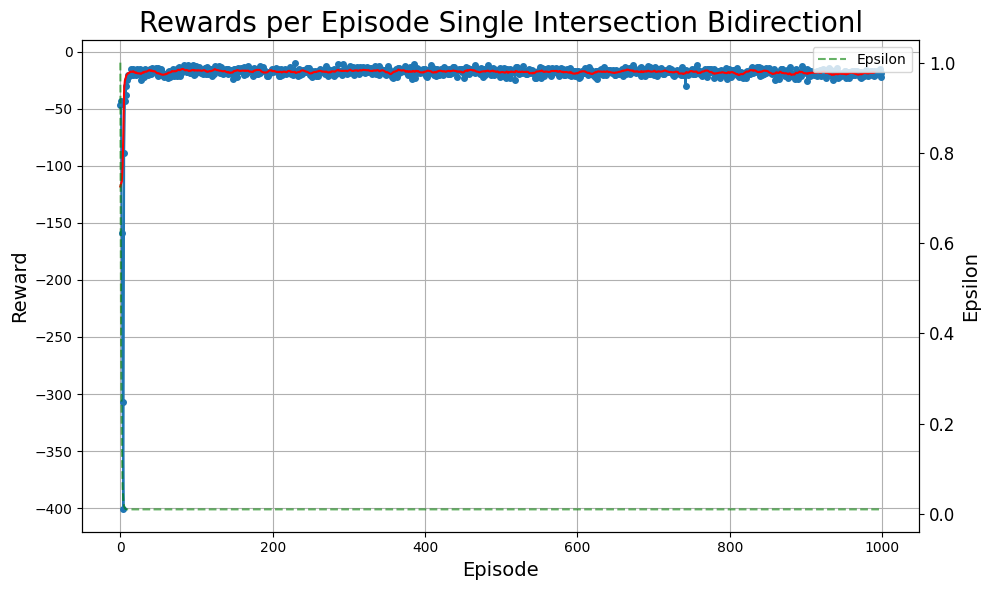

<module 'matplotlib.pyplot' from 'c:\\Users\\ASUS\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [31]:
print("Average Rewards:", np.mean(ddqn_rewards))
rewards_per_episode_plot_2(ddqn_rewards_per_episode, 'Single Intersection Bidirectionl', ddqn_epsilon_values, window_size=10)

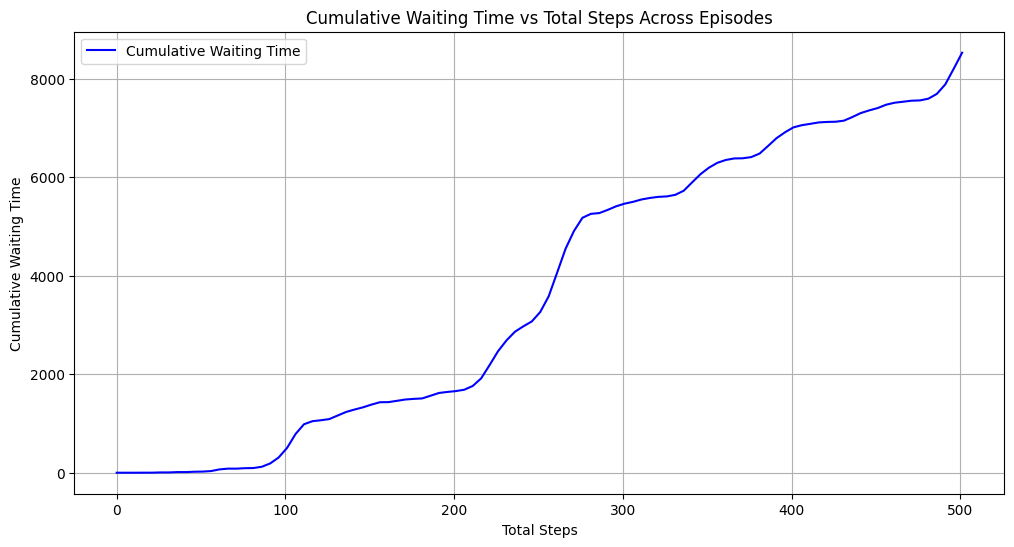

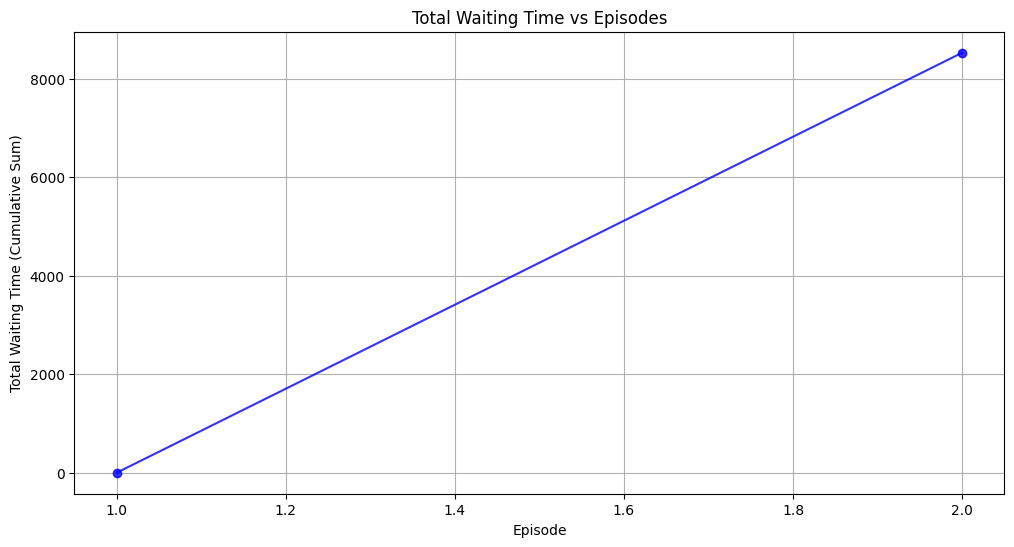

In [32]:
plot_results_csv_per_step(folder_path="nets/ddqn_results_csv", plot_steps=True, plot_episodes=False)
plot_results_csv_per_episode(folder_path="nets/ddqn_results_csv")

In [35]:
torch.save(ddqn_agent.q_network.state_dict(), 'sumo_ddqn2way.pth')

In [39]:
# ddqn_rewards, ddqn_losses, ddqn_rewards_per_episode, ddqn_epsilon_values
torch.save(ddqn_rewards, "ddqn2way_rewards.pkl")
torch.save(ddqn_losses, "ddqn2way_losses.pkl")
torch.save(ddqn_rewards_per_episode, "ddqn2way_rewards_per_episode.pkl")
torch.save(ddqn_epsilon_values, "ddqn2way_epsilon_values.pkl")

In [36]:
model = DQN(sumo_env_ddqn.observation_space, sumo_env_ddqn.action_space.n)
model.load_state_dict(torch.load('sumo_ddqn2way.pth'))

greedy_avg_rewards_over_eps, greedy_rewards_per_eps, epsilon_values = greedy_agent(ddqn_agent,  model, sumo_env_ddqn ,n_episodes=100)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14292\2855411023.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('sumo_ddqn2way.pth'))


Observation size Network 21
Action size Network 4


Testing Progress:   0%|          | 0/100 [00:00<?, ?Episode/s]

Testing Progress: 100%|██████████| 100/100 [19:11<00:00, 11.51s/Episode]


Avg Rewards per episode for Greedy Agent:  -18.5256


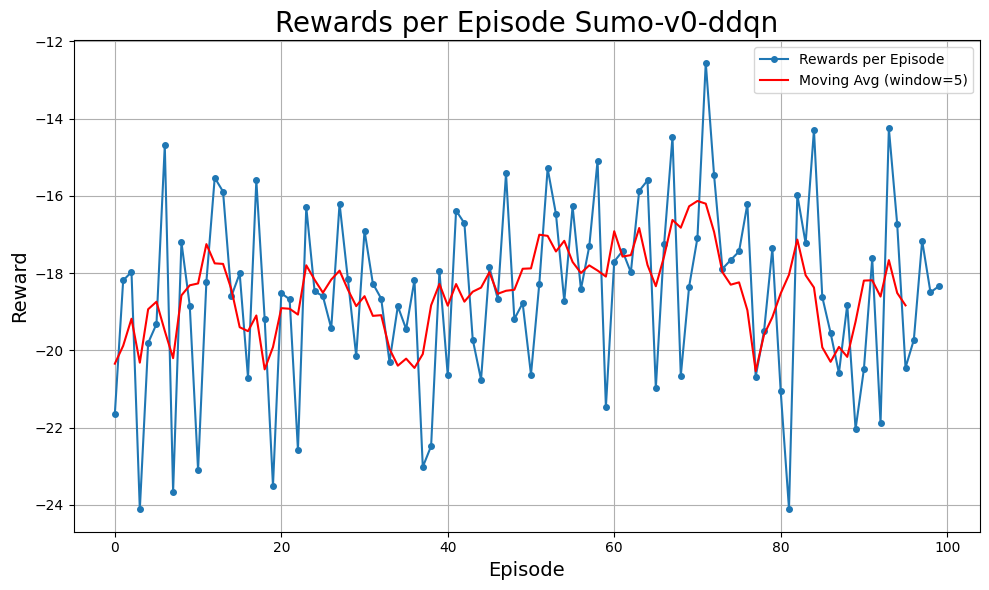

<module 'matplotlib.pyplot' from 'c:\\Users\\ASUS\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [37]:
print("Avg Rewards per episode for Greedy Agent: ", greedy_avg_rewards_over_eps)
rewards_per_episode_plot_2(greedy_rewards_per_eps, 'Sumo-v0-ddqn', window_size=5)

## Saving the simulation with the best Epsiode reward DDQN

In [ ]:
model = DQN(sumo_env_ddqn.observation_space, sumo_env_ddqn.action_space.n)
model.load_state_dict(torch.load(os.path.join('saved_variables', 'sumo_ddqn2way.pth')))

env = Environment('sumo-rl-v0', 
                 net_file=nets_file, 
                 route_file=routes_file, 
                 out_csv_name=out_csv_name, 
                 render_mode=None,  # Enable GUI
                 num_seconds=num_seconds)

save_path = "best_simulation_record/ddqn2way"

if os.path.exists(save_path):
    shutil.rmtree(save_path)
    os.makedirs(save_path, exist_ok=True)

greedy_agent_with_best_recording(ddqn_agent, model, env, num_seconds=num_seconds ,n_episodes=10, save_path=save_path)

Observation size Network 21
Action size Network 4


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14292\1617579224.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join('saved_variable

Env and Traci closed successfully.


Finding Best Episode: 100%|██████████| 10/10 [01:56<00:00, 11.63s/Episode]


Best episode reward: -16.31
Env and Traci closed successfully.
 Retrying in 1 seconds
Episode completed with reward: -18.36
Env and Traci closed successfully.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14292\1152363643.py:99: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(save_path, filename)))


Frame images cleaned up successfully


(-16.31,
 {0: (2340, -18.96),
  1: (6435, -18.77),
  2: (7423, -19.88),
  3: (9626, -16.86),
  4: (1169, -16.31),
  5: (2899, -19.87),
  6: (6987, -19.11),
  7: (5890, -21.1),
  8: (9710, -21.65),
  9: (3179, -18.36)})

# Comparison plots for DQN and DDQN

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14292\426672466.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ddqn_rewards = torch.load(os.path.join(dir_path, 'ddqn2way_rew

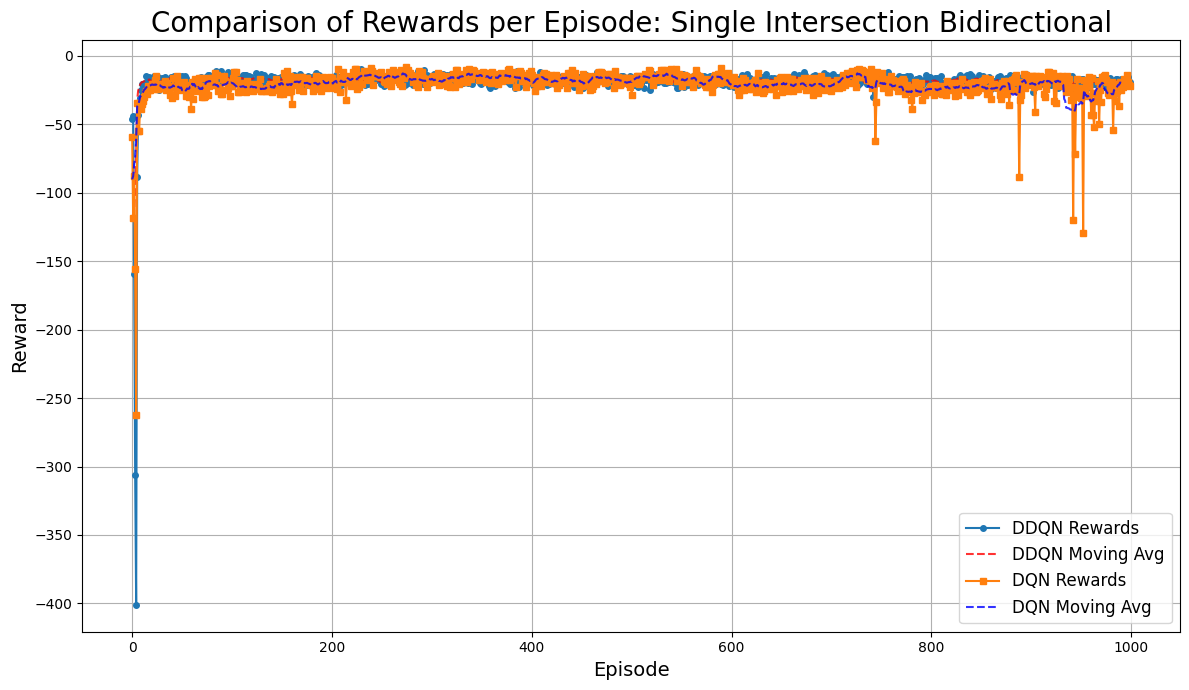

<module 'matplotlib.pyplot' from 'c:\\Users\\ASUS\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [43]:
dir_path = 'saved_variables'

# Load DDQN variables
ddqn_rewards = torch.load(os.path.join(dir_path, 'ddqn2way_rewards.pkl'))
ddqn_losses = torch.load(os.path.join(dir_path, 'ddqn2way_losses.pkl'))
ddqn_rewards_per_episode = torch.load(os.path.join(dir_path, 'ddqn2way_rewards_per_episode.pkl'))
ddqn_epsilon_values = torch.load(os.path.join(dir_path, 'ddqn2way_epsilon_values.pkl'))

# Load DQN variables
dqn_rewards = torch.load(os.path.join(dir_path, 'dqn2way_rewards.pkl'))
dqn_losses = torch.load(os.path.join(dir_path, 'dqn2way_losses.pkl'))
dqn_rewards_per_episode = torch.load(os.path.join(dir_path, 'dqn2way_rewards_per_episode.pkl'))
dqn_epsilon_values = torch.load(os.path.join(dir_path, 'dqn2way_epsilon_values.pkl'))

# rewards_per_episode_plot_2(ddqn_rewards_per_episode, 'Single Intersection Simple DDQN', epsilons=ddqn_epsilon_values, window_size=10)
# rewards_per_episode_plot_2(dqn_rewards_per_episode, 'Single Intersection Simple DQN', epsilons=dqn_epsilon_values, window_size=10)

combined_rewards_plot(ddqn_rewards_per_episode, dqn_rewards_per_episode, ('DDQN', 'DQN'), 'Single Intersection Bidirectional', window_size=10)


## Saving the simulation with the best Epsiode reward DDQN

In [ ]:
# Saving simulation of greedy agent